# Finetuning the LLAMA 3.2 with Pure Pytorch and Using QLoRA

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, get_scheduler
from bitsandbytes.optim import Adam8bit,PagedAdam32bit
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from peft import prepare_model_for_kbit_training
import torch
from IPython.display import  clear_output
import time
import gc
from torch.utils.data import Dataset, DataLoader

def print_gpu_utilization():
    allocated = torch.cuda.memory_allocated() / (1024 ** 2)
    reserved = torch.cuda.memory_reserved() / (1024 ** 2)
    print(f"GPU Memory Usage>>>> Allocated: {allocated:.2f} MB |||||  Reserved:  {reserved:.2f} MB:")

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DEFAULT_MODEL = "meta-llama/Llama-3.2-1B-Instruct"

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
    )


model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    quantization_config=bnb_config,
    use_safetensors=True,
    device_map=device,
)

print(model.get_memory_footprint()/(1024*1024)) 

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.eos_token_id


965.1290283203125


# Load an Instruction Finetuned Dataset

In [2]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("OdiaGenAI/hardcode_odia_qa_105")

README.md:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

hardcode_qa.json:   0%|          | 0.00/61.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/105 [00:00<?, ? examples/s]

In [4]:
small_dataset=[]

for example in dataset['train']:
    small_dataset.append({
        "instruction": example['instruction'],
        "output": example['output']
    })
    
small_dataset[0]

{'instruction': 'ଆପଣ କିଏ?',
 'output': 'ମୁଁ ଅଲିଭ୍ ଏକ ଚାଟ୍ବଟ୍ ଆସିଷ୍ଟାଣ୍ଟ, ଯାହାକି ଓଡିଆ-ଜେନ-ଏ.ଆଇ. ଗବେଷକମାନଙ୍କ ଦ୍ୱାରା ପ୍ରଶିକ୍ଷିତ ଏକ ଭାଷା ମଡେଲ।'}

In [2]:
small_dataset = [
  {
    "instruction": "Summarize the IPL 2024 season.",
    "output": "The 2024 Indian Premier League (IPL) was a thrilling season filled with memorable moments, outstanding performances, and intense competition. Kolkata Knight Riders (KKR) emerged as the champions, defeating Sunrisers Hyderabad (SRH) in the final. The season witnessed remarkable individual performances, high-scoring matches, and competitive qualifier stages."
  },
  {
    "instruction": "Who won the IPL in 2024?",
    "output": "Kolkata Knight Riders (KKR) won the IPL in 2024."
  },
  {
    "instruction": "Which teams played in the final of IPL 2024?",
    "output": "Kolkata Knight Riders (KKR) and Sunrisers Hyderabad (SRH) played in the final of IPL 2024."
  },
  {
    "instruction": "Describe the performance of Kolkata Knight Riders in IPL 2024.",
    "output": "Kolkata Knight Riders (KKR) showcased dominant performances throughout the season and emerged as the champions, defeating Sunrisers Hyderabad (SRH) in the final to clinch their third IPL title."
  },
  {
    "instruction": "What were some of the key highlights of IPL 2024?",
    "output": "Some of the key highlights of IPL 2024 include Kolkata Knight Riders (KKR) winning the tournament, dominant performances from several teams, remarkable individual performances from both batsmen and bowlers, and many high-scoring matches."
  },
    {
    "instruction": "How were the qualifier matches in IPL 2024?",
    "output": "The qualifier matches in IPL 2024 were very competitive. KKR and SRH both displayed strong performances to reach the final. Royal Challengers Bengaluru (RCB) and Rajasthan Royals (RR) also played well in the eliminator stages."
  },
  {
    "instruction": "What was special about the final match of IPL 2024?",
    "output": "The final match of IPL 2024 was a highly anticipated clash between Kolkata Knight Riders and Sunrisers Hyderabad. KKR dominated the match, securing a comfortable victory and winning the IPL title."
  },
  {
    "instruction": "Did IPL 2024 have any last ball thrillers?",
    "output": "Yes, many matches throughout the IPL 2024 season had nail-biting finishes, with last-ball thrillers and unexpected comebacks."
  },
  {
    "instruction": "How was the performance of young cricketers in IPL 2024?",
    "output": "The IPL 2024 tournament showcased a mix of experienced players and emerging talent, with several young cricketers making a mark."
  },
  {
      "instruction": "Write a summary of IPL 2024",
      "output": "The 2024 IPL season was a thrilling and successful tournament, filled with excitement, drama, and outstanding cricket. Kolkata Knight Riders won the title, defeating Sunrisers Hyderabad in the final.  Many matches featured high scores and nail-biting finishes.  The tournament showcased a mix of experienced and young talented players."
  }
]

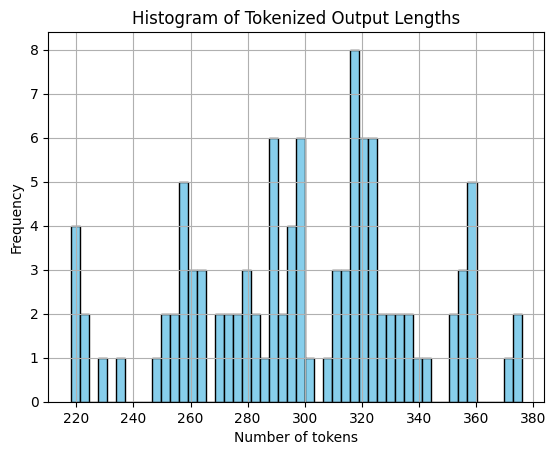

In [5]:
import matplotlib.pyplot as plt
lengths = [len(tokenizer(example['instruction']+example['output'])['input_ids']) for example in small_dataset]

# Plot the histogram
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Tokenized Output Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [7]:
from transformers import pipeline

llama_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

messages = [
    {"role": "user", "content": small_dataset[0]['instruction']},
]

generated_text = llama_pipeline(messages, max_new_tokens=60, early_stopping=True)

print(generated_text[0]['generated_text'])

Device set to use cuda


[{'role': 'user', 'content': 'ଆପଣ କିଏ?'}, {'role': 'assistant', 'content': '"ଆପଣ" (Apob)  ଇ ଏ କો. ଏ. ଆ ଏ ଆ ଏ ଆ ଏ ଆ ଏ ଆ �'}]


## Create the Dataset Object for Pytorch-Dataset

In [8]:
# Custom PyTorch Dataset
class LlamaDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        question=sample['instruction']
        answer = sample['output']
        prompt = f'''<|begin_of_text|> <|start_header_id|>user<|end_header_id|>\n\n{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'''
        full_text = prompt+f'''{answer}<|eot_id|>'''

        tokenized = tokenizer(full_text, truncation=True, add_special_tokens=False, padding="max_length", max_length=300)

        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]

        # Tokenize just the prompt to get the split point
        prompt_ids = tokenizer(prompt, add_special_tokens=False)["input_ids"]
        answer_start = len(prompt_ids)

        # Mask everything before answer_start
        labels = [-100] * answer_start + input_ids[answer_start:]
        # Mask out padding as well
        labels = [
            label if token != tokenizer.pad_token_id else -100
            for label, token in zip(labels, input_ids)
        ]
    
        return {
        "input_ids": torch.tensor(input_ids),
        "attention_mask": torch.tensor(attention_mask),
        "labels": torch.tensor(labels)
    }
        

In [9]:
train_dataset = LlamaDataset(small_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [10]:
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

model = get_peft_model(model, config)



model.print_trainable_parameters()

trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039


In [11]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

base_model.model.model.embed_tokens.weight  dtype: torch.float16  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model

In [12]:
# Now manually move LoRA params to bf16
for name, param in model.named_parameters():
    if "lora_" in name:
        param.data = param.data.to(torch.bfloat16)
        if param.requires_grad:
            param.grad = None  # Reset grads just in case

for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

base_model.model.model.embed_tokens.weight  dtype: torch.float16  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.

# Finetune the LLAMA model on a single text

In [13]:
def generate_eval(model,idx=5,disable_lora=False):
    
    model.config.use_cache = True
    sample=small_dataset[idx]
    question=sample['instruction']
    answer = sample['output']
    chat_template = f'''<|begin_of_text|> <|start_header_id|>user<|end_header_id|>\n\n{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'''
    inputs = tokenizer(chat_template , return_tensors="pt", add_special_tokens=False).to(device)
    # print(prompt)

    model.eval()


    if disable_lora:
        with model.disable_adapter():
            output = model.generate(
                **inputs,
                do_sample=True,
                max_new_tokens=200,
                repetition_penalty=1.3,
                temperature=0.7,         # Optional: smooth randomness
                top_k=50,                # Optional: top-k sampling
                top_p=0.9                # Optional: nucleus sampling
            )
    else:
        output = model.generate(
        **inputs,
        do_sample=True,
        max_new_tokens=200,
        repetition_penalty=1.3,
        temperature=0.7,         # Optional: smooth randomness
        top_k=50,                # Optional: top-k sampling
        top_p=0.9                # Optional: nucleus sampling
        )

    processed_text = tokenizer.decode(output[0], skip_special_tokens=False)
    
    model.train()

    return processed_text

In [14]:
small_dataset[4]

{'instruction': 'ଆପଣ କିଏ?',
 'output': 'ମୁଁ ଅଲିଭ୍ ଏକ ଚାଟ୍ବଟ୍ ଆସିଷ୍ଟାଣ୍ଟ ନାମକ ଏକ ଭାଷା ମଡେଲ୍ ଏବଂ ଓଡିଆ-ଜେନ-ଏ.ଆଇ. ଗବେଷକମାନଙ୍କ ଦ୍ୱାରା ପ୍ରଶିକ୍ଷିତ ହୋଇଛି।'}

In [15]:
pred = generate_eval(model=model,idx=4,disable_lora=False)
print(pred)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|> <|start_header_id|>user<|end_header_id|>

ଆପଣ କିଏ?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

"apa la apna khana " 

“apa” অর্থ - “সাধৃতে”
“Apa La Apa Khane” 
- (Apan) – A pan
(Alap Ana) -(లే దా)
(Lapan Alupani, a lepan alupni or lopan al upi i.e. Lopa lopane and etc.)

   મૂળભોગ<|eot_id|>


In [16]:
print_gpu_utilization()
flush()

GPU Memory Usage>>>> Allocated: 1052.81 MB |||||  Reserved:  1548.00 MB:


KeyboardInterrupt: 

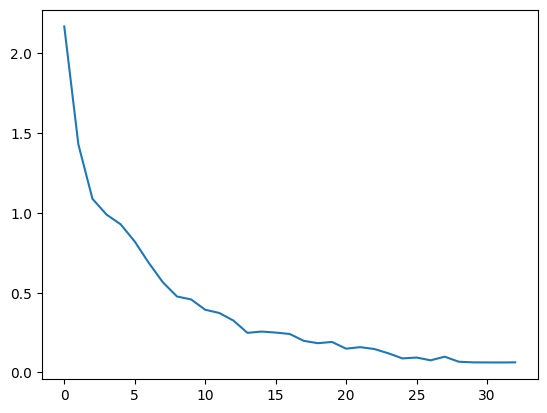

In [17]:
model.config.use_cache = False
model.config.pretraining_tp = 1
gradient_accumulation_steps = 4
max_steps=500
max_loss = 1e9

from torch.optim import AdamW
# Define optimizer
params_to_optimize = list(filter(lambda p: p.requires_grad, model.parameters()))
optimizer = AdamW(params_to_optimize, lr=1e-5)
# optimizer = Adam8bit(params_to_optimize, lr=1e-4)

# Training loop
model.train()

global_step= 0
running_loss = []

while global_step< max_steps:
    for step,batch in enumerate(train_dataloader):
        model.config.use_cache = False
        model.train()
        
        # Forward pass
        outputs = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'), labels=batch['labels'].to('cuda'))
        loss = outputs.loss
        running_loss.append(loss.item())
        loss.backward()
        

        optimizer.step()
        optimizer.zero_grad()
        
        global_step += 1
        if global_step >= max_steps:
            break
        
        clear_output(wait=True)
        plt.plot(running_loss)
        plt.title(f"Epoch {global_step + 1}/{max_steps}, Loss: {loss.item():.4f}")
        plt.show()
        print_gpu_utilization()
 
        
flush()

In [18]:
pred = generate_eval(model=model,idx=4,disable_lora=False)
print(pred)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|> <|start_header_id|>user<|end_header_id|>

ଆପଣ କିଏ?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ମୋ ବଂ-ସଞ଍ ବଁ ଅଲିଭ୍ ନାମରେ ଫଳିତ ଓଡ଼-ଜେନ-ଏ.ଆଈ ଗବେଷକମାନଙ୍କ ଦ୍ୱାରା ଚାଟୁକାନଙ୍କ ମୁଁ ଓଡିଆ-ଜ�


In [19]:
small_dataset[4]

{'instruction': 'ଆପଣ କିଏ?',
 'output': 'ମୁଁ ଅଲିଭ୍ ଏକ ଚାଟ୍ବଟ୍ ଆସିଷ୍ଟାଣ୍ଟ ନାମକ ଏକ ଭାଷା ମଡେଲ୍ ଏବଂ ଓଡିଆ-ଜେନ-ଏ.ଆଇ. ଗବେଷକମାନଙ୍କ ଦ୍ୱାରା ପ୍ରଶିକ୍ଷିତ ହୋଇଛି।'}

# Saving the LoRA Adapter

In [58]:
model.save_pretrained('adapter')

In [59]:
del model
flush()

# Loading back the model and adding the LoRA adapter

In [17]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, get_scheduler,pipeline
from bitsandbytes.optim import Adam8bit,PagedAdam32bit
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from peft import prepare_model_for_kbit_training
import torch
from IPython.display import  clear_output
import time
import gc
from torch.utils.data import Dataset, DataLoader

def print_gpu_utilization():
    allocated = torch.cuda.memory_allocated() / (1024 ** 2)
    reserved = torch.cuda.memory_reserved() / (1024 ** 2)
    print(f"GPU Memory Usage>>>> Allocated: {allocated:.2f} MB |||||  Reserved:  {reserved:.2f} MB:")

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DEFAULT_MODEL = "meta-llama/Llama-3.2-1B-Instruct"

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
    )


model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    quantization_config=bnb_config,
    use_safetensors=True,
    device_map=device,
)

print(model.get_memory_footprint()/(1024*1024)) 

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.eos_token_id


965.1290283203125


In [61]:
# Load the adapter into the base model
model = PeftModel.from_pretrained(model, 'adapter')
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

In [ ]:
from datasets import load_dataset

dataset = load_dataset("tatsu-lab/alpaca")
# Select only the first 200 rows
small_dataset = []
for i, example in enumerate(dataset['train']):
    if i >= 200:# I only kept 200 rows
        break
    small_dataset.append(example)

In [19]:
small_dataset[0]

{'instruction': 'Summarize the IPL 2024 season.',
 'output': 'The 2024 Indian Premier League (IPL) was a thrilling season filled with memorable moments, outstanding performances, and intense competition. Kolkata Knight Riders (KKR) emerged as the champions, defeating Sunrisers Hyderabad (SRH) in the final. The season witnessed remarkable individual performances, high-scoring matches, and competitive qualifier stages.'}

In [69]:
llama_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

messages = [
    {"role": "user", "content": "Who is gonna win IPL?"}
]

generated_text = llama_pipeline(messages, max_new_tokens=60, early_stopping=True)

print(generated_text[0]['generated_text'][-1]['content'])

Device set to use cuda
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForC

The Indian Premier League (IPL) is an ongoing and dynamic competition, and the outcome of the tournament can change rapidly. As of my knowledge cutoff in December 2023, the teams that were likely to perform well in the upcoming season included the Royal Challengers Bangalore, the Chennai Super Kings,
